<a href="https://colab.research.google.com/github/SHYXIN/100-Days-Of-ML-Code/blob/master/Copy_of_LSTM_Time_Series_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np

In [18]:
csv_path = '/content/ESK2033-good.csv'
df = pd.read_csv(csv_path, parse_dates=['Date Time Hour Beginning'], index_col=0)  # 读取好的数据，手动改一下
# 担心数据不是按时间排序的，这里按照索引排序
df.sort_index(inplace=True)

# 第一列为用电量，即y
df.head()

,RSA Contracted Forecast,Dispatchable Generation,Residual Demand,RSA Contracted Demand,International Exports,International Imports,Thermal Generation,Nuclear Generation,Eskom Gas Generation,Eskom OCGT Generation,...,Total RE Installed Capacity,Installed Eskom Capacity,Total PCLF,Total UCLF,Total OCLF,Total UCLF+OCLF,Non Comm Sentout,Drakensberg Gen Unit Hours,Palmiet Gen Unit Hours,Ingula Gen Unit Hours
Date Time Hour Beginning,,,,,,,,,,,,,,,,,,,,,
2018-04-01 00:00:00,20367.066,20237.0,20237.0,20722.058,1215.902,1120.0,19444.0,931,0,0.0,...,3873.69,44546,3987.472,8028.710,275.907,8304,617.0,81.8,36.9,30.41
2018-04-01 01:00:00,19988.733,19744.0,19744.0,20188.493,1203.474,1106.0,19297.0,930,0,0.0,...,3873.69,44546,3987.472,7727.302,244.907,7972,209.0,83.0,38.5,32.85
2018-04-01 02:00:00,19731.239,19631.0,19631.0,20019.603,1177.571,1117.0,19165.0,931,0,0.0,...,3873.69,44546,3987.472,7704.704,193.727,7898,431.0,83.8,40.3,35.60
2018-04-01 03:00:00,19753.554,19731.0,19731.0,20079.454,1184.312,1118.0,19279.0,930,0,0.0,...,3873.69,44546,3990.072,7702.868,187.000,7889,868.0,85.0,42.0,37.76
2018-04-01 04:00:00,19988.365,19890.0,19890.0,20237.490,1197.271,1108.0,19369.0,930,0,0.0,...,3873.69,44546,3990.472,7685.115,187.000,7872,115.0,85.8,43.7,40.32


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37704 entries, 2018-04-01 00:00:00 to 2022-07-19 23:00:00
Data columns (total 39 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   RSA Contracted Forecast      37704 non-null  float64
 1   Dispatchable Generation      37704 non-null  float64
 2   Residual Demand              37704 non-null  float64
 3   RSA Contracted Demand        37704 non-null  float64
 4   International Exports        37704 non-null  float64
 5   International Imports        37704 non-null  float64
 6   Thermal Generation           37704 non-null  float64
 7   Nuclear Generation           37704 non-null  int64  
 8   Eskom Gas Generation         37704 non-null  int64  
 9   Eskom OCGT Generation        37704 non-null  float64
 10  Hydro Water Generation       37704 non-null  int64  
 11  Pumped Water Generation      37704 non-null  int64  
 12  ILS Usage                    37704 non-

In [20]:
df.isna().sum()  # 查看有缺失值

RSA Contracted Forecast         0
Dispatchable Generation         0
Residual Demand                 0
RSA Contracted Demand           0
International Exports           0
International Imports           0
Thermal Generation              0
Nuclear Generation              0
Eskom Gas Generation            0
Eskom OCGT Generation           0
Hydro Water Generation          0
Pumped Water Generation         0
ILS Usage                       0
Manual Load_Reduction(MLR)      0
IOS Excl ILS and MLR            0
Dispatchable IPP OCGT           0
Eskom Gas SCO                   0
Eskom OCGT SCO                  0
Hydro Water SCO                 0
Pumped Water SCO Pumping        0
Wind                            0
PV                              0
CSP                             0
Other RE                        0
Total RE                        0
Wind Installed Capacity         0
PV Installed Capacity           0
CSP Installed Capacity          0
Other RE Installed Capacity     0
Total RE Insta

In [21]:
df[df['Ingula Gen Unit Hours'].isna()]  # 并非一个时间段，是多个分散的时间点，处理这个些确实值，使用线性填充


,RSA Contracted Forecast,Dispatchable Generation,Residual Demand,RSA Contracted Demand,International Exports,International Imports,Thermal Generation,Nuclear Generation,Eskom Gas Generation,Eskom OCGT Generation,...,Total RE Installed Capacity,Installed Eskom Capacity,Total PCLF,Total UCLF,Total OCLF,Total UCLF+OCLF,Non Comm Sentout,Drakensberg Gen Unit Hours,Palmiet Gen Unit Hours,Ingula Gen Unit Hours
Date Time Hour Beginning,,,,,,,,,,,,,,,,,,,,,
2018-08-03 09:00:00,30754.674,29416.512,29416.512,30827.866,1639.738,1320.0,23828.220,1723,0,0.0,...,3875.73,44432,1718.000,8523.706,3494.294,12018,611.000,36.1,34.790,NaN
2018-08-28 16:00:00,29302.135,28179.302,28289.302,29803.843,1695.686,1279.0,24941.032,1628,0,0.0,...,3875.73,44432,2336.297,5701.000,1027.000,6728,660.002,45.6,36.320,NaN
2018-09-06 00:00:00,22273.725,21963.156,21963.156,22462.734,1616.465,1100.0,21790.886,1598,0,0.0,...,3875.73,44257,2751.414,5718.276,1242.724,6961,724.000,41.7,33.990,NaN
2018-09-23 09:00:00,27861.956,25994.487,25994.487,27533.565,1737.178,1318.0,23114.087,910,0,0.0,...,3875.73,44257,5844.017,6549.075,632.925,7182,687.000,53.6,58.810,NaN
2018-11-07 13:00:00,28892.956,26225.020,26225.020,28447.523,1642.052,1042.0,23045.020,918,0,0.0,...,3875.73,44072,5729.766,9540.114,395.886,9936,750.004,17.1,20.800,NaN
2018-12-13 20:00:00,29076.716,28081.814,28081.814,29397.659,1770.941,1150.0,22606.526,902,0,1223.0,...,3975.73,44072,4439.040,10623.360,987.640,11611,728.000,38.1,43.420,NaN
2019-01-23 04:00:00,24039.119,23592.044,23592.044,24099.378,1537.248,1226.0,22189.644,1843,0,0.0,...,3975.73,44072,4877.377,9366.267,488.733,9855,1197.000,28.2,36.770,NaN
2019-02-28 11:00:00,29126.274,26288.610,26288.610,28820.733,1493.064,1128.0,21598.610,1837,0,949.0,...,4075.73,44072,4540.000,11427.910,512.090,11940,1044.000,33.7,40.450,NaN
2019-04-06 18:00:00,29111.334,28100.000,28100.000,29183.309,1586.516,987.0,22614.000,1848,0,1016.0,...,4075.73,44104,7565.000,7775.993,407.007,8183,1183.003,31.0,35.160,NaN


In [22]:
# 线性填充
df['Ingula Gen Unit Hours'].interpolate(method='linear', inplace=True)

In [23]:
df.isna().sum()  # 查看是否填充成功，看到没有缺失值了

RSA Contracted Forecast        0
Dispatchable Generation        0
Residual Demand                0
RSA Contracted Demand          0
International Exports          0
International Imports          0
Thermal Generation             0
Nuclear Generation             0
Eskom Gas Generation           0
Eskom OCGT Generation          0
Hydro Water Generation         0
Pumped Water Generation        0
ILS Usage                      0
Manual Load_Reduction(MLR)     0
IOS Excl ILS and MLR           0
Dispatchable IPP OCGT          0
Eskom Gas SCO                  0
Eskom OCGT SCO                 0
Hydro Water SCO                0
Pumped Water SCO Pumping       0
Wind                           0
PV                             0
CSP                            0
Other RE                       0
Total RE                       0
Wind Installed Capacity        0
PV Installed Capacity          0
CSP Installed Capacity         0
Other RE Installed Capacity    0
Total RE Installed Capacity    0
Installed 

<Axes: xlabel='Date Time Hour Beginning'>

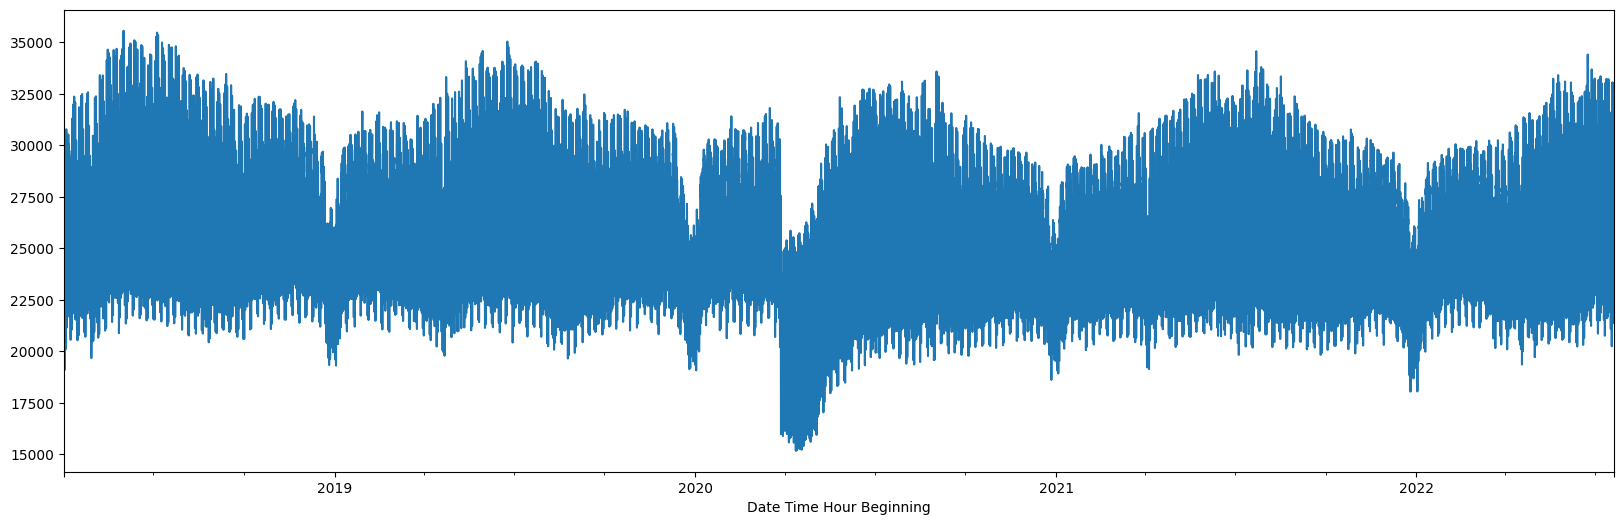

In [27]:
temp = df['RSA Contracted Forecast']
temp.plot(figsize=(20, 6))

In [32]:
# [[[1], [2], [3], [4], [5]]] [6]
# [[[2], [3], [4], [5], [6]]] [7]
# [[[3], [4], [5], [6], [7]]] [8]
# 关键的数据处理，将dataframe进行平移
def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [33]:
WINDOW_SIZE = 5
X1, y1 = df_to_X_y(temp, WINDOW_SIZE)
X1.shape, y1.shape

((37699, 5, 1), (37699,))

In [65]:
X1[1], y1

(array([[19988.733],
        [19731.239],
        [19753.554],
        [19988.365],
        [20600.806]]),
 array([20600.806, 21560.2  , 23447.173, ..., 27637.313, 24723.511,
        22833.06 ]))

In [34]:
X_train1, y_train1 = X1[:60000], y1[:60000]
X_val1, y_val1 = X1[60000:65000], y1[60000:65000]
X_test1, y_test1 = X1[65000:], y1[65000:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((37699, 5, 1), (37699,), (0, 5, 1), (0,), (0, 5, 1), (0,))

In [62]:
X1

array([[[20367.066],
        [19988.733],
        [19731.239],
        [19753.554],
        [19988.365]],

       [[19988.733],
        [19731.239],
        [19753.554],
        [19988.365],
        [20600.806]],

       [[19731.239],
        [19753.554],
        [19988.365],
        [20600.806],
        [21560.2  ]],

       ...,

       [[29294.506],
        [30870.618],
        [33010.62 ],
        [32385.459],
        [30482.268]],

       [[30870.618],
        [33010.62 ],
        [32385.459],
        [30482.268],
        [27637.313]],

       [[33010.62 ],
        [32385.459],
        [30482.268],
        [27637.313],
        [24723.511]]])

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((5, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [56]:
cp1 = ModelCheckpoint('model1/', save_best_only=True, monitor='val_accuracy', mode='min')   # 这有问题，待会再保存吧
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])


In [58]:
model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=10,
          #  callbacks=[cp1]
           )

Epoch 1/10
1179/1179 [==============================] - 4s 3ms/step - loss: 594355392.0000 - root_mean_squared_error: 24379.4043
Epoch 2/10
1179/1179 [==============================] - 4s 4ms/step - loss: 590477184.0000 - root_mean_squared_error: 24299.7363
Epoch 3/10
1179/1179 [==============================] - 4s 3ms/step - loss: 586532800.0000 - root_mean_squared_error: 24218.4395
Epoch 4/10
1179/1179 [==============================] - 4s 3ms/step - loss: 582524544.0000 - root_mean_squared_error: 24135.5449
Epoch 5/10
1179/1179 [==============================] - 4s 3ms/step - loss: 578453632.0000 - root_mean_squared_error: 24051.0625
Epoch 6/10
1179/1179 [==============================] - 4s 3ms/step - loss: 574321472.0000 - root_mean_squared_error: 23965.0059
Epoch 7/10
1179/1179 [==============================] - 5s 4ms/step - loss: 570128768.0000 - root_mean_squared_error: 23877.3691
Epoch 8/10
1179/1179 [==============================] - 5s 4ms/step - loss: 565876544.0000 - root

In [59]:
# 过程中保存有问题，先不保存了
# from tensorflow.keras.models import load_model
# model1 = load_model('model1/')

In [60]:
train_predictions = model1.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

1179/1179 [==============================] - 2s 1ms/step


,Train Predictions,Actuals
0,2766.386719,20600.806
1,2766.386719,21560.200
2,2766.386719,23447.173
3,2766.386719,25242.639
4,2766.386719,25795.037
...,...,...
37694,2766.386719,32385.459
37695,2766.386719,30482.268
37696,2766.386719,27637.313
37697,2766.386719,24723.511


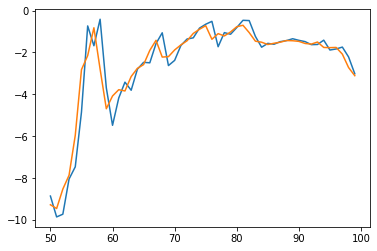

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'][50:100])
plt.plot(train_results['Actuals'][50:100])

In [ ]:
val_predictions = model1.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val1})
val_results

,Val Predictions,Actuals
0,15.410512,14.02
1,13.227476,13.67
2,13.021247,12.27
3,11.453429,11.19
4,10.364747,10.85
...,...,...
4995,17.421888,18.27
4996,17.372950,17.85
4997,17.177311,16.65
4998,15.872609,15.85


# 新段落